In [2]:
#processing
import pandas as pd
import scikitplot as skplt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from pandas import ExcelWriter
import scipy
scaler = StandardScaler()
#sql
import pymysql.cursors
#NLP
import nltk
import re
import pymorphy2
from nltk.tokenize import sent_tokenize, RegexpTokenizer
from nltk.stem.snowball import RussianStemmer
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#warnings
import warnings
warnings.filterwarnings('ignore')
#visualisation
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)
%matplotlib inline
#vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
#model
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, f1_score, confusion_matrix, precision_score, recall_score, classification_report, accuracy_score
#classificators
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [3]:
#Подключиться к базе данных
def con():
    conn = pymysql.connect(host='192.168.64.1', port=3306, user='i.serov', password='X3*1Uy(F', db='mysql')
    return conn

In [1]:
%%time
df = pd.read_sql('''
SELECT
  c.id as credit_id,
  c.date_requested,
  #if(c.status in ('ACTIVE', 'COMPLETED', 'EXPIRED', 'SOLD'), 1, 0) as is_accepted,
  c.status,
                  ifnull(IF(c.status IN ('active','completed','expired'),
                  (SELECT
                    IF((COUNT(credit_payment.id) > 0 OR CURDATE() < LEAST(c.due_date,DATE(c.date_received) + INTERVAL 31 DAY) + INTERVAL 16 DAY),0,1)
                  FROM br_release_moneyman.credit_payment
                  WHERE ((credit_payment.credit_id = c.id) AND (credit_payment.payment_date <(LEAST(c.due_date,DATE(c.date_received) + INTERVAL 31 DAY) + INTERVAL 16 DAY)))),NULL),0)
                  AS npl15,
  vr.*,
  va.*,
  vi.*,
  vo.*,
  vd.*,
  vam.*
FROM
  br_release_moneyman.credit c 
  INNER JOIN br_release_moneyman.borrower b on b.id = c.borrower_id
  INNER JOIN br_release_moneyman.verumview_report vr on vr.user_account_id=b.user_account_id
  LEFT JOIN br_release_moneyman.verumview_addressmatch va on vr.id = va.verumview_report_id
  LEFT JOIN br_release_moneyman.verumview_income vi on vr.id = vi.verumview_report_id
  LEFT JOIN br_release_moneyman.verumview_overduebills vo on vr.id = vo.verumview_report_id
  LEFT JOIN (
              SELECT
                Count(DISTINCT id) as cnt_id,
                sum(number_of_msgs) as number_of_msgs,
                min(days_since_last_msg) as min_days_since_last_msg,
                min(domain_name) as min_name,
                verumview_report_id
              FROM
                br_release_moneyman.verumview_dispute
              GROUP BY
                verumview_report_id) vd
      on vr.id = vd.verumview_report_id
  LEFT JOIN (
              SELECT
                sum(spend_amount) as sum_spend_amount,
                sum(transactions) as sum_transactions,
                #count_transactions
                sum(if(months_back=5, transactions, 0)) as cnt_Trans_5,
                sum(if(months_back=4, transactions, 0)) as cnt_Trans_4,
                sum(if(months_back=3, transactions, 0)) as cnt_Trans_3,
                sum(if(months_back=2, transactions, 0)) as cnt_Trans_2,
                sum(if(months_back=1, transactions, 0)) as cnt_Trans_1,
                sum(if(months_back=0, transactions, 0)) as cnt_Trans_0,
                #sum_transactions
                sum(if(months_back=5, spend_amount, 0)) as sum_Trans_5,
                sum(if(months_back=4, spend_amount, 0)) as sum_Trans_4,
                sum(if(months_back=3, spend_amount, 0)) as sum_Trans_3,
                sum(if(months_back=2, spend_amount, 0)) as sum_Trans_2,
                sum(if(months_back=1, spend_amount, 0)) as sum_Trans_1,
                sum(if(months_back=0, spend_amount, 0)) as sum_Trans_0,
                verumview_report_id
              FROM
                br_release_moneyman.verumview_amount
              GROUP BY
                verumview_report_id) vam
      on vr.id = vam.verumview_report_id
where c.date_requested>'2017-09-01' and c.date_requested<'2018-02-01' and c.status in ('ACTIVE', 'COMPLETED', 'EXPIRED', 'SOLD')
#WHERE c.status in ('ACTIVE', 'COMPLETED', 'EXPIRED', 'SOLD', 'CANCELLED');
''', con=con())

NameError: name 'pd' is not defined

In [4]:
df1 = df.copy()

In [5]:
df_accepted = df[df.is_accepted == 1].drop(['is_accepted', 'status'], axis = 1)
df_declined = df[df.is_accepted == 0].drop(['is_accepted', 'status'], axis = 1)

In [18]:
df = df_accepted.copy()

# Preprocessing Functions

In [6]:
# FIND SUMM OF DIGITS IN ROW
def sum_of_digits(x):
    try:
        return (sum([int(i) for i in re.findall('\d+', x)]))
    except:
        return 0


# WHAT CREDIT DID THE PERSON TAKE


def what_credit(x):
    try:
        if x.find('moneyman') != -1:
            return 12
        elif x.find('easycredito') != -1:
            return 11
        elif x.find('bompracredito') != -1:
            return 10
        elif x.find('lendico') != -1:
            return 9
        elif x.find('simplic') != -1:
            return 8
        elif x.find('justonline') != -1:
            return 7
        elif x.find('credbel') != -1:
            return 6
        elif x.find('trigg') != -1:
            return 5
        elif x.find('creditas') != -1:
            return 4
        elif x.find('geru') != -1:
            return 3
        elif x.find('ferratum') != -1:
            return 2
        else:
            return 1
    except:
        return 0

# FULL PREPROCESSING
def preproc(df):
    df.drop(
        [
            'id', 'date_requested', 'customer_uniq_id', 'user_account_id',
            'verumview_report_id', 'currency', 'date_recieved', 'name'
        ],
        axis=1,
        inplace=True)
    df.drop_duplicates(inplace=True)

    df['name_match'] = df['name_match'].map({
        'PartialMatchFirst': 1,
        'PartialMatchLast': 1,
        'MatchLastOnly': 2,
        'MatchFirstOnly': 2,
        'FullNameMatch': 3
    })
    df['mail_age_attribute'] = df['mail_age_attribute'].map({
        'New': 1,
        'Young': 2,
        'Medium': 3,
        'Old': 4
    })
    df['mail_earliest'] = df['mail_earliest'].map({
        'New': 1,
        'Young': 2,
        'Medium': 3,
        'Reliable': 4
    })
    df['mail_reliability'] = df['mail_reliability'].map({
        'Suspicious': 1,
        'LowUseInbox': 2,
        'Reliable': 3,
        'Trusted': 4
    })
    df['is_online_shopper'] = df['is_online_shopper'].map({
        'OfflineShopper': 1,
        'CasualShopper': 2,
        'MediumShopper': 3,
        'HeavyShopper': 4
    })
    df['mail_match'] = df['mail_match'].map({
        'No Match': 1,
        'DomainMatchOnly': 2,
        'UsernameMatchOnly': 3,
        'EmailMatched': 4
    })
    df['match_type'] = df['match_type'].map({
        'No PostcodeMatch': 1,
        'CityAndStreetMatch': 2,
        'FullMatch': 3
    })
    df['cv_attribute'] = pd.isnull(df['cv_attribute']).replace(True, 1)
    df['job_title'] = pd.isnull(df['job_title']).replace(True, 1)
    df['company'] = pd.isnull(df['company']).replace(True, 1)
    df['customer_email'] = df.customer_email.map(lambda x: x.split("@", 1)[1])
    df['customer_email'] = df['customer_email'].map(lambda x: 1 if x.find('gmail.com') != -1 
                                                    else (2 if x.find('hotmail.com') != -1 
                                                          else (3 if x.find('outlook.com') != -1 
                                                               else (4 if x.find('live.com') != -1 else 5))))
    
    df['prev_payday_loat_count'] = df.prev_payday_loat_taker.map(
        lambda x: sum_of_digits(x))
    df.prev_payday_loat_taker = df.prev_payday_loat_taker.map(
        lambda x: what_credit(x))
    df.fillna(0, inplace=True)
    df.index = range(len(df.index))
    df['is_gambler'] = df.is_gambler.map(
        lambda x: 0 if x == 0 else (1 if x == '[]' else 2))
    df.min_name = df.min_name.map(lambda x: 0 if x == 0 else 1)

    X = pd.DataFrame(
        df.drop(['npl15', 'credit_id'], axis=1),
        columns=df.drop(['npl15', 'credit_id'], axis=1).columns,
        index=df.drop(['npl15', 'credit_id'], axis=1).index)
    y = df.npl15
    return X, y, df

In [7]:
#df.name.map(lambda x: re.sub('[0-9,:;/()-]', ' ', x))

In [8]:
X, y, df = preproc(df) 

In [9]:
df.shape

(32106, 71)

# Model

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=1)

In [191]:
clf = GradientBoostingClassifier(random_state=0, verbose=1)
tuned_parameters = [{'learning_rate': np.arange(0.2, 1, 0.2)},
                    {'n_estimators': np.arange(60, 200, 20)},
                    {'max_depth': np.arange(2, 6, 1)}]
gs = GridSearchCV(clf, tuned_parameters, cv=5, verbose=True)

In [192]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
      Iter       Train Loss   Remaining Time 
         1           1.0491            0.20s
         2           1.0102            0.20s
         3           0.9866            0.16s
         4           0.9610            0.17s
         5           0.9287            0.17s
         6           0.9073            0.17s
         7           0.8985            0.16s
         8           0.8802            0.16s
         9           0.8650            0.15s
        10           0.8556            0.15s
        20           0.7341            0.12s
        30           0.6444            0.10s
        40           0.5686            0.09s
        50           0.5046            0.07s
        60           0.4527            0.06s
        70           0.3984            0.04s
        80           0.3591            0.03s
        90           0.3300            0.01s
       100           0.3040            0.00s
      Iter       Train Loss   Remainin

        30           0.4106            0.09s
        40           0.3319            0.08s
        50           0.2698            0.07s
        60           0.2131            0.05s
        70           0.1760            0.03s
        80           0.1481            0.03s
        90           0.1276            0.01s
       100           0.1089            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.9924            0.00s
         2           0.9346            0.00s
         3           0.8567            0.00s
         4           0.8329            0.00s
         5           0.7874            0.30s
         6           0.7442            0.24s
         7           0.7138            0.21s
         8           0.6876            0.18s
         9           0.6479            0.16s
        10           0.6270            0.14s
        20           0.4199            0.13s
        30           0.2969            0.07s
        40           0.2321            0.07s
        5

        90           0.0481            0.01s
       100           0.0421            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.0707            0.12s
         2           1.0473            0.09s
         3           1.0313            0.08s
         4           1.0098            0.08s
         5           0.9956            0.08s
         6           0.9830            0.08s
         7           0.9690            0.08s
         8           0.9556            0.08s
         9           0.9396            0.09s
        10           0.9291            0.09s
        20           0.8612            0.07s
        30           0.8035            0.05s
        40           0.7458            0.03s
        50           0.6992            0.02s
        60           0.6507            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.0682            0.24s
         2           1.0469            0.17s
         3           1.0298            0.17s
        

        20           0.8191            0.14s
        30           0.7555            0.12s
        40           0.7005            0.09s
        50           0.6482            0.07s
        60           0.6063            0.06s
        70           0.5648            0.04s
        80           0.5328            0.03s
        90           0.4999            0.01s
       100           0.4731            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.0694            0.10s
         2           1.0467            0.15s
         3           1.0265            0.13s
         4           1.0098            0.14s
         5           0.9916            0.21s
         6           0.9785            0.22s
         7           0.9620            0.23s
         8           0.9479            0.22s
         9           0.9335            0.20s
        10           0.9191            0.20s
        20           0.8057            0.17s
        30           0.7449            0.14s
        4

        20           0.8191            0.23s
        30           0.7555            0.20s
        40           0.7005            0.17s
        50           0.6482            0.15s
        60           0.6063            0.11s
        70           0.5648            0.10s
        80           0.5328            0.09s
        90           0.4999            0.07s
       100           0.4731            0.06s
      Iter       Train Loss   Remaining Time 
         1           1.0694            0.41s
         2           1.0467            0.41s
         3           1.0265            0.37s
         4           1.0098            0.34s
         5           0.9916            0.32s
         6           0.9785            0.38s
         7           0.9620            0.38s
         8           0.9479            0.40s
         9           0.9335            0.38s
        10           0.9191            0.35s
        20           0.8057            0.29s
        30           0.7449            0.25s
        4

      Iter       Train Loss   Remaining Time 
         1           1.0682            0.45s
         2           1.0469            0.36s
         3           1.0298            0.35s
         4           1.0063            0.36s
         5           0.9892            0.32s
         6           0.9718            0.32s
         7           0.9584            0.32s
         8           0.9440            0.30s
         9           0.9285            0.31s
        10           0.9173            0.29s
        20           0.8191            0.26s
        30           0.7555            0.19s
        40           0.7005            0.19s
        50           0.6482            0.14s
        60           0.6063            0.15s
        70           0.5648            0.14s
        80           0.5328            0.13s
        90           0.4999            0.11s
       100           0.4731            0.11s
      Iter       Train Loss   Remaining Time 
         1           1.0694            0.17s
        

        40           0.7458            0.12s
        50           0.6992            0.10s
        60           0.6507            0.08s
        70           0.6079            0.06s
        80           0.5736            0.04s
        90           0.5412            0.02s
       100           0.5121            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.0682            0.00s
         2           1.0469            0.15s
         3           1.0298            0.17s
         4           1.0063            0.17s
         5           0.9892            0.15s
         6           0.9718            0.16s
         7           0.9584            0.16s
         8           0.9440            0.15s
         9           0.9285            0.15s
        10           0.9173            0.15s
        20           0.8191            0.12s
        30           0.7555            0.10s
        40           0.7005            0.08s
        50           0.6482            0.07s
        6

        70           0.3989            0.06s
        80           0.3629            0.04s
        90           0.3264            0.02s
       100           0.2975            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.0483            0.00s
         2           1.0136            0.00s
         3           0.9755            0.00s
         4           0.9323            0.00s
         5           0.8982            0.00s
         6           0.8675            0.24s
         7           0.8444            0.21s
         8           0.8217            0.18s
         9           0.8024            0.16s
        10           0.7823            0.14s
        20           0.6154            0.19s
        30           0.5146            0.18s
        40           0.4386            0.15s
        50           0.3702            0.13s
        60           0.3184            0.10s
        70           0.2679            0.08s
        80           0.2349            0.05s
        9

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   12.9s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=1,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'learning_rate': array([ 0.2,  0.4,  0.6,  0.8])}, {'n_estimators': array([ 60,  80, 100, 120, 140, 160, 180])}, {'max_depth': array([2, 3, 4, 5])}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=True)

In [193]:
print("Best parameters set:")
best_parameters = gs.best_estimator_.get_params()
print (best_parameters)

Best parameters set:
{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 80, 'presort': 'auto', 'random_state': 0, 'subsample': 1.0, 'verbose': 1, 'warm_start': False}


In [11]:
#best estimator
clf = GradientBoostingClassifier(random_state=0, verbose = 0,
                                 learning_rate = 0.1,
                                 max_depth = 3,
                                 n_estimators = 80).fit(X, y)

# Score

Confusion Matrix:
[[330  82]
 [  1  20]]


ROC_AUC:  0.876675913084
Gini:  0.753351826167
F1_score:  0.325203252033


Classification_report: 
              precision    recall  f1-score   support

          0       1.00      0.80      0.89       412
          1       0.20      0.95      0.33        21

avg / total       0.96      0.81      0.86       433





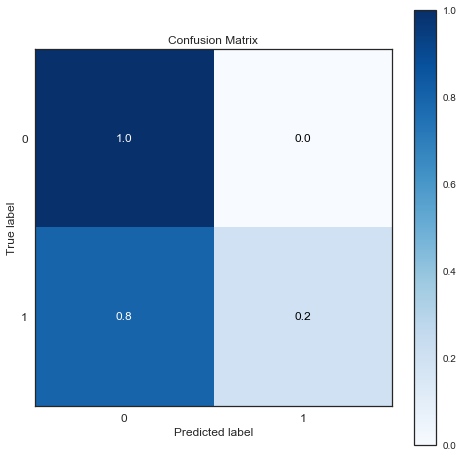

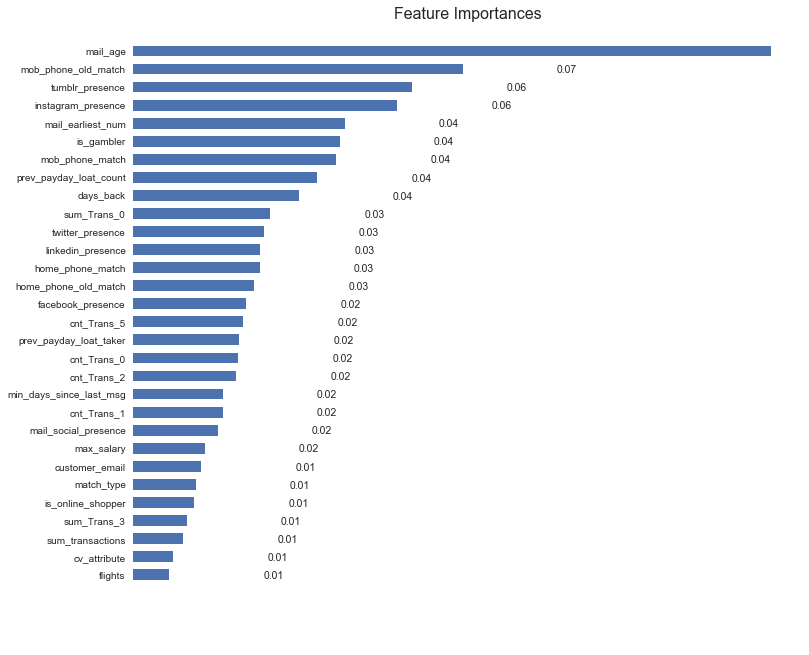

In [12]:
import IDF
IDF.plot_score(clf, X_test, y_test)

In [68]:
print ('ROC_AUC: ', roc_auc_score(gs.predict(X_test), y_test))
print ('Gini: ', 2*roc_auc_score(gs.predict(X_test), y_test) - 1)
print ('F1_score: ', f1_score(gs.predict(X_test), y_test), '\n')
print ('Confusion matrix: \n', confusion_matrix(gs.predict(X_test), y_test), '\n')
print ('Classification_report : \n', classification_report(gs.predict(X_test), y_test))

ROC_AUC:  0.800520684866
Gini:  0.601041369732
F1_score:  0.899204244032 

Confusion matrix: 
 [[ 257   74]
 [1370 6441]] 

Classification_report : 
              precision    recall  f1-score   support

          0       0.16      0.78      0.26       331
          1       0.99      0.82      0.90      7811

avg / total       0.95      0.82      0.87      8142



In [195]:
print ('ROC_AUC: ', roc_auc_score(clf.predict(X_test), y_test))
print ('Gini: ', 2*roc_auc_score(clf.predict(X_test), y_test) - 1)
print ('F1_score: ', f1_score(clf.predict(X_test), y_test), '\n')
print ('Confusion matrix: \n', confusion_matrix(clf.predict(X_test), y_test), '\n')
print ('Classification_report : \n', classification_report(clf.predict(X_test), y_test))

ROC_AUC:  0.873342175066
Gini:  0.746684350133
F1_score:  0.494623655914 

Confusion matrix: 
 [[275  44]
 [  3  23]] 

Classification_report : 
              precision    recall  f1-score   support

          0       0.99      0.86      0.92       319
          1       0.34      0.88      0.49        26

avg / total       0.94      0.86      0.89       345



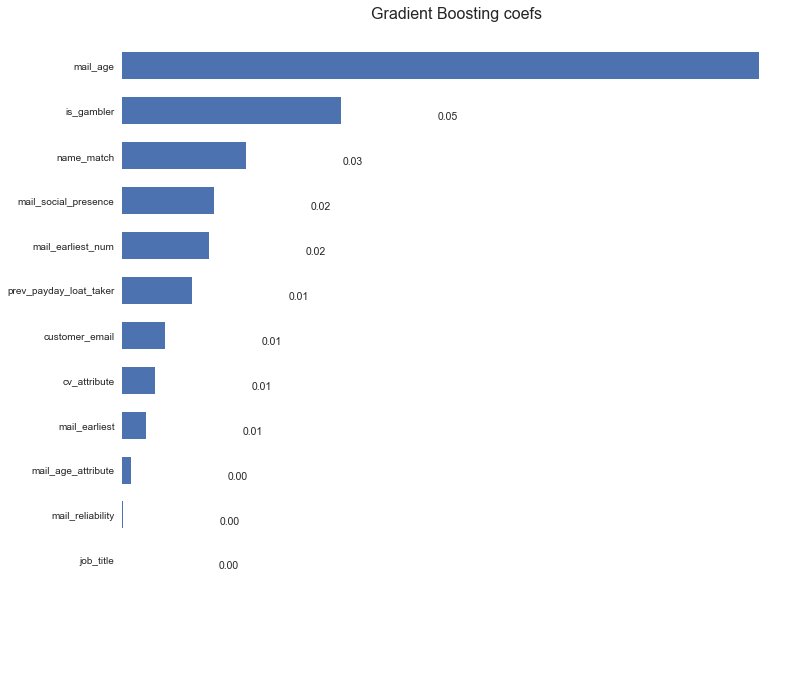

In [196]:
imp = pd.DataFrame(list(zip(X.columns, clf.feature_importances_)))
imp = imp[:12]
imp = imp.reindex(imp[1].abs().sort_values().index).set_index(0)
#график_фич
ax = imp.plot.barh(width = .6, legend = "", figsize = (12, 10))
ax.set_title("Gradient Boosting coefs", y = 1.03, fontsize = 16.)
_ = ax.set(frame_on = False, xlabel = "", xticklabels = "", ylabel = "")
for i, labl in enumerate(list(imp.index)):
    score = imp.loc[labl][1]
    ax.annotate('%.2f' % score, (score + (-.12 if score < 0 else .02), i - .2), fontsize = 10.5)
plt.savefig('without_coefs.png')

# Reject inference

In [197]:
df_end = pd.concat([df_declined, df_accepted])
df_declined_1, y1 = preproc(df_declined)
df_accepted, y2 = preproc(df_accepted)
#df_accepted.drop('npl15', axis = 1, inplace = True)
#df_declined_1.drop('npl15', axis = 1, inplace = True)

In [198]:
df_accepted['npl15'] = y2
df_declined_1['npl15'] = pd.DataFrame(clf.predict_proba(df_declined_1)[:, 0], columns=[
                                      'npl15']).npl15.apply(lambda x: np.random.choice([0, 1], p=[1 - x, x]))

In [199]:
df_new_to_train = pd.concat([df_declined_1, df_accepted])
y_new_to_train = df_new_to_train.npl15
df_new_to_train.drop('npl15', axis = 1, inplace = True)

In [200]:
X_train, X_test, y_train, y_test = train_test_split(df_new_to_train, y_new_to_train, test_size=0.33, random_state=1)

In [201]:
#best estimator
clf = GradientBoostingClassifier(random_state=0, verbose = 0,
                                 learning_rate = 0.1,
                                 max_depth = 3,
                                 n_estimators = 100).fit(X_train, y_train)

In [231]:
print ('ROC_AUC: ', roc_auc_score(clf.predict(X_test), y_test))
print ('Gini: ', 2*roc_auc_score(clf.predict(X_test), y_test) - 1)
print ('F1_score: ', f1_score(clf.predict(X_test), y_test), '\n')
print ('Confusion matrix: \n', confusion_matrix(clf.predict(X_test), y_test), '\n')
print ('Classification report : \n', classification_report(clf.predict(X_test), y_test))

ROC_AUC:  0.700631342122
Gini:  0.401262684244
F1_score:  0.838629192045 

Confusion matrix: 
 [[ 230  114]
 [2085 5714]] 

Classification report : 
              precision    recall  f1-score   support

          0       0.10      0.67      0.17       344
          1       0.98      0.73      0.84      7799

avg / total       0.94      0.73      0.81      8143



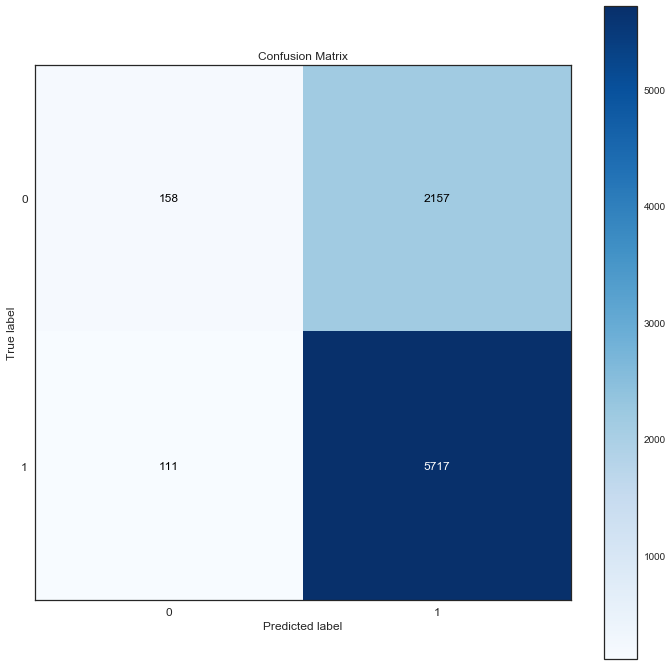

In [203]:
skplt.metrics.plot_confusion_matrix(y_test, clf.predict(X_test), title="Confusion Matrix",
                normalize=False,figsize=(12,12),text_fontsize='large');

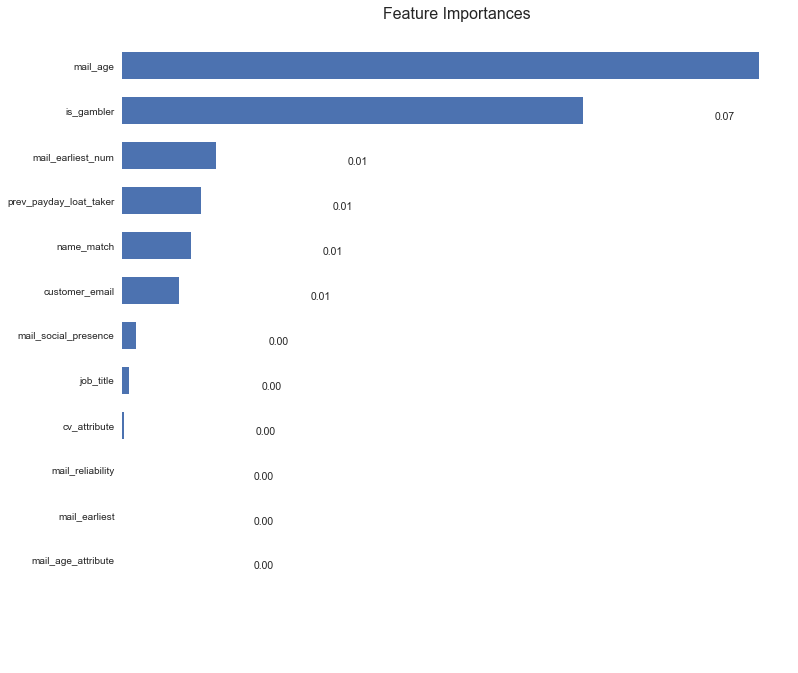

In [230]:
imp = pd.DataFrame(list(zip(df_new_to_train.columns, clf.feature_importances_)))
imp = imp[:12]
imp = imp.reindex(imp[1].abs().sort_values().index).set_index(0)
#график_фич
ax = imp.plot.barh(width = .6, legend = "", figsize = (12, 10))
ax.set_title("Feature Importances", y = 1.03, fontsize = 16.)
_ = ax.set(frame_on = False, xlabel = "", xticklabels = "", ylabel = "")
for i, labl in enumerate(list(imp.index)):
    score = imp.loc[labl][1]
    ax.annotate('%.2f' % score, (score + (-.12 if score < 0 else .02), i - .2), fontsize = 10.5)
plt.savefig('without_coefs.png')

# Predictions and out

In [12]:
from sklearn.externals import joblib
clf = joblib.load('vv_algorithm.pkl');

In [25]:
def vv_data(df, clf):
    df1.drop(
        [
            'id', 'date_requested', 'customer_uniq_id', 'user_account_id',
            'verumview_report_id', 'currency', 'date_recieved', 'name'
        ],
        axis=1,
        inplace=True)
    df1.drop_duplicates(inplace=True)
    final = df1[['credit_id', 'npl15']]
    final['VV_pred_proba'] = clf.predict_proba(X)[:,1]
    final['VV_pred'] = clf.predict(X)
    final.drop('npl15', axis=1, inplace=True)
    return final

In [26]:
final = vv_data(df, clf)

In [27]:
final

,credit_id,VV_pred_proba,VV_pred
0,51521,0.522089,1
1,52620,0.522089,1
2,52696,0.522089,1
3,51541,0.470182,0
4,59252,0.470182,0
5,51564,0.470182,0
6,53724,0.470182,0
7,65934,0.470182,0
8,51560,0.470182,0
9,51567,0.470182,0


In [24]:
X.drop(['is_accepted', 'status'], axis=1, inplace=True)

In [28]:
writer = pd.ExcelWriter('VV_DATA_ALL.xlsx')
final.to_excel(writer,'VV', index=False)
writer.save()

# Without gambler

In [ ]:
'''PD = pd.DataFrame(clf.predict_proba(X)[:,1], columns = ['PD'])
NPL = y1.reset_index()
dates = df[['credit_id', 'date_requested']].drop_duplicates()
export = pd.concat([pd.merge(NPL, dates, how = 'inner', on = 'credit_id'), PD], axis = 1)'''

# Export algorithm

In [227]:
clf = GradientBoostingClassifier(random_state=0, verbose = 0,
                                 learning_rate = 0.1,
                                 max_depth = 3,
                                 n_estimators = 100).fit(df_new_to_train, y_new_to_train) 

In [228]:
from sklearn.externals import joblib
joblib.dump(clf, 'vv_algorithm.pkl');